# NFT Floor Price Prediction

This notebook shows how to use Covalent API to acquire historic data to build a floor price prediction model for Bored Ape Yacht Club (BAYC) collection. The model can be also used to predict other NFT collections by simply changing the NFT contract address.

## 1. Introduction

There are generally two types of price prediction that buyers are interested in:

1.   **Collection Floor Price Prediction:** To predict the lowest price of the entire collection on any given day.
2.   **Token Price Prediction:** To predict the average (or floor) price of a specific token wihtin one NFT collection. i.e. within the Chromie Squiggle collection, based on the different traits and features and historic sale price of the specific token, what is the price on any given day.

This notebook will only cover the floor price prediction model. The token price prediction can also be performed by acquiring token level data, such as traits, token level transactions and prices. 


In [1]:
import requests
import json
import pandas as pd
import numpy as np
import covalent_api as c
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import datetime
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import accuracy_score, r2_score, precision_score
from PIL import Image
import requests
from io import BytesIO
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':300})

def fetch_collection_hist(address):
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/nft_market/collection/{address}/'
    url = api_url + endpoint
    r = requests.get(url, auth=(auth_key,''))
    input_data = r.json()
    input_data = input_data['data']['items']
    out = pd.DataFrame.from_records(input_data)
    return(out)

def fetch_token_id(address): 
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/tokens/{address}/nft_token_ids/'
    url = api_url + endpoint
    r = requests.get(url, auth=(auth_key,''))
    input_data = r.json()
    # input_data = input_data['data']['items']
    # out = pd.DataFrame.from_records(input_data)
    return(input_data)

def fetch_token_tx(address, token_id):
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/tokens/{address}/nft_transactions/{token_id}/'
    url = api_url + endpoint
    r = requests.get(url, auth=(auth_key,''))
    input_data = r.json()
    # input_data = input_data['data']['items']
    # out = pd.DataFrame.from_records(input_data)
    return(input_data)


def fetch_token_meta(address, token_id):
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/tokens/{address}/nft_metadata/{token_id}/'
    url = api_url + endpoint
    r = requests.get(url, auth=(auth_key,''))
    input_data = r.json()
    input_data = input_data['data']['items'][0]['nft_data']
    out = pd.DataFrame.from_records(input_data)
    out_2 = pd.DataFrame.from_records(out['external_data'])
    out_table = pd.DataFrame({'token_id': out['token_id']
                              ,'token_balance': out['token_balance']
                              ,'image_url': out_2['image']
                              ,'traits': out_2['attributes']})

    trait = pd.DataFrame.from_records(out_table['traits'][0])

    trait.loc[:,'token_id'] = out_table['token_id']
    trait['token_id'] = out_table['token_id'].tolist() * len(trait)
    trait['image_url'] = out_table['image_url'].tolist() * len(trait)

              
    return(trait,out)

def stationary_test(x):

    out = adfuller(x.dropna())
    print('ADF Statistic: %f' % out[0])
    print('p-value: %f' % out[1])
    if out[1] <= 0.05:
        print('Time-series is stationary at 5% significance level.')
    else:
        print('Time-series is non-stationary at 5% significance level. Find the order of difference!')


# Accuracy metrics
def accuracy(y_hat, y):
    mape = np.mean(np.abs(y_hat - y)/np.abs(y))     
    rmse = np.mean((y_hat - y)**2)**0.5
    corr = np.corrcoef(y_hat, y)[0,1]   


    return({'Mean absolute percentage error':mape
            , 'Root mean squared error':rmse
            , 'corr':corr})

In [2]:
#####################################################
#Input Covalent API Authentication Key:
#####################################################

auth_key = 'ckey_b2b7d1edb69a4a7ba64aa7b8c36' #my_key
#auth_key = 'ckey_840e54e45ce943b189adf6d23c4' #alex_key

## 2. Data Preparation

The historic NFT data can be downloaded from Covalent API by specifying the NFT contract address.

In [3]:
################################################
## Input NFT contract address below: 
################################################
nft_address = '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d' 
#'0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB' cryptopunks
#'0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d' monkeys
#'0x73DA73EF3a6982109c4d5BDb0dB9dd3E3783f313' my curio cards
#'0xc3f733ca98E0daD0386979Eb96fb1722A1A05E69' Moon Cats
#'0xA08126f5E1ED91A635987071E6FF5EB2aEb67C48' Galaxy Eggs


In [4]:
###################################
## Read in historic floor prices ##
###################################

## Read in floor price 
try:
    data = fetch_collection_hist(nft_address)
except TypeError:
    print("Data taken from the pickle")
    data = data = pd.read_pickle("./monkey_pickle.pkl")
    

data['opening_date'] = pd.to_datetime(data['opening_date'])
data = data.sort_values(by='opening_date', ascending=True)
data.set_index('opening_date', inplace=True)

## Plot floor price
name = np.unique(data['collection_name']).tolist()
plt.plot( data["floor_price_quote_7d"])
plt.title("Historical floor price "+str(name))
plt.xlabel("time")
plt.ylabel("price")
plt.show()


Data taken from the pickle


KeyError: 'opening_date'

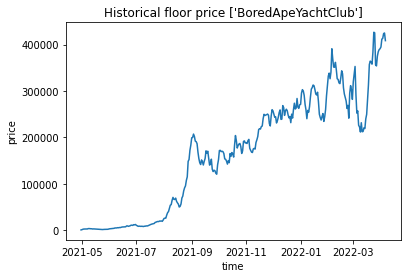

In [5]:
name = np.unique(data['collection_name']).tolist()
plt.plot( data["floor_price_quote_7d"])
plt.title("Historical floor price "+str(name))
plt.xlabel("time")
plt.ylabel("price")
plt.show()

The daily data of Bored Ape Yacht Club (BAYC) shows the full history of the NFT from April 30th 2020 to January 15th 2021, which is the time this data was downloaded from Covalent. 

You can also input a specific token ID to check out the traits and see the image.

In [ ]:
######################################
## ༼ つ ◕_◕ ༽つ Input a token ID below:
######################################
#tokenId = '22'

## Display the NFT & its traits
#token_meta,out = fetch_token_meta(nft_address, tokenId)
#print("The "+token_meta["trait_type"]+" is: "+token_meta["value"])
#url = token_meta['image_url'][0]
#response = requests.get(url)
#Image.open(BytesIO(response.content))

## 3. Floor Price Prediction Models
### 3.1 Model Options
The dependent variable to predict is the floor price of a given NFT collection. Since the past sale price is usually a good indicator of the future price, this can be interpreted as the prediction of a time-dependent event:
```
Y(c|tn) = f(w,x,Y(c|t0,...,tn-1))
```
where Y is the floor price of collection c at time tn and x represents the time dependent independent variables;  Y from t0 to tn-1 represent the past prices that can be used to model the price now. 

We know the prices of a lot NFTs have sky-rocketed since last year and there is surely a trend in the price. Given most of the time-series models require stationarity (no trend) in the data, generally Y needs to be transformed into a difference in order to remove trending in the price:
```
dY(c|t) = f(w,x,dY(c|t0,...,tn-1))
```
where dY is the percentage change in price of the collection (or token) c from month t-1 to t. 

Some of the most commonly used time-series models are:

- [Autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model)
- [ARMA](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model)
- [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

Since ARIMA model incorporates the differencing terms dY(c|t), the lag of the difference dY(c|t-1) and the lag of the error terms e(c|t), as an example for demonstration, the last option ARIMA is chosen to predict the floor price in the below sections.

### 3.2 ARIMA
ARIMA models are generally the most general class of models for forecasting a time series which can be made to be “stationary” by differencing (see more details [here](https://people.duke.edu/~rnau/411arim.htm)). The model form ARIMA(p,d,q) comes with three components: 
- p is the number of autoregressive terms,
- d is the number of nonseasonal differences needed for stationarity, and
- q is the number of lagged forecast errors in the prediction equation. 

#### 3.2.1 Stationary

In order to decide what values of p, d and q to use in the ARIMA model, it's useful to have a look at floor price data itself, its first difference (or second or higher differences) along with its autocorrelation function [ACF](https://en.wikipedia.org/wiki/Autocorrelation) and partial autocorrelation function [PACF](https://en.wikipedia.org/wiki/Partial_autocorrelation_function).

The plots below show that the original daily floor price time-sereis is trending (non-stationary). Once the first difference is used, the series becomes stationary as shown in the ACF and PACF plots. The second difference is over-differencing as shown by the over-shooting lag from ACF and PACF. 



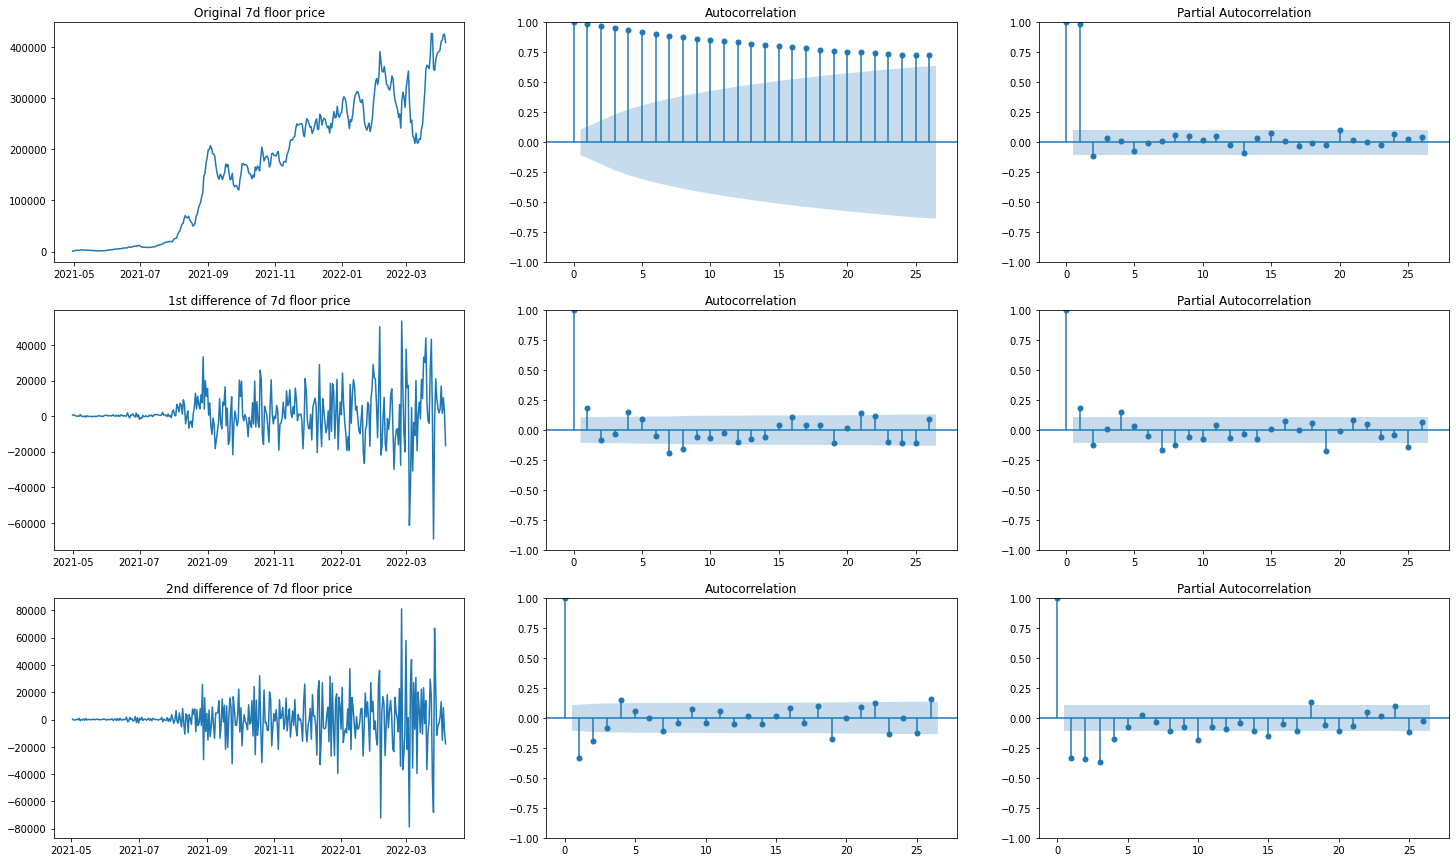

In [6]:
########################################
## Plot floor price & its differences ##
########################################
## Original floor price
fig, axes = plt.subplots(3, 3, sharex=False, figsize=(25,15))
diff0 = data['floor_price_quote_7d']
axes[0,0].plot(diff0); axes[0, 0].set_title('Original 7d floor price')
plot_acf(diff0.dropna(), ax=axes[0, 1])
axes[0,1].axis(xmin=-2, xmax=28)
plot_pacf(diff0.dropna(), ax=axes[0, 2], method='ywm')
axes[0,2].axis(xmin=-2, xmax=28)

## 1st diff
diff1 = data['floor_price_quote_7d'].diff()
axes[1,0].plot(diff1); axes[1, 0].set_title('1st difference of 7d floor price')
plot_acf(diff1.dropna(), ax=axes[1, 1])
axes[1,1].axis(xmin=-2, xmax=28)
plot_pacf(diff1.dropna(), ax=axes[1, 2], method='ywm')
axes[1,2].axis(xmin=-2, xmax=28)

## 2nd diff
## lag goes too far negative => over-differenced!
diff2 = data['floor_price_quote_7d'].diff().diff()
axes[2,0].plot(diff2); axes[2, 0].set_title('2nd difference of 7d floor price')
plot_acf(diff2.dropna(), ax=axes[2, 1])
plot_pacf(diff2.dropna(), ax=axes[2, 2], method='ywm')
plt.show()


The stationarity Augmented Dickey–Fuller [ADF](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) tests below also show the same statistically, where p value becomes small after first differencing. So we have an idea only first differencing (d=1) is needed to turn the trending data into stationary.

In [ ]:
#data.to_pickle("./monkey_pickle.pkl")

In [7]:
## Stationarity Tests
stationary_test(diff0) ## non-stationary
stationary_test(diff1) ## stationary
stationary_test(diff2)

ADF Statistic: -0.388872
p-value: 0.911940
Time-series is non-stationary at 5% significance level. Find the order of difference!
ADF Statistic: -7.845918
p-value: 0.000000
Time-series is stationary at 5% significance level.
ADF Statistic: -6.891005
p-value: 0.000000
Time-series is stationary at 5% significance level.


#### 3.2.2 Training, testing data split

In order to test better how the ARIMA model performs, the whole dataset is split into 80% for training and 20% for testing.

In [8]:
############################
## Training testing split ##
############################
v_index = []
for i in range(0,len(data)):
    v_index.append(i)

v_index = v_index.reverse()

train_size = round(len(data)*0.8)

train = data.floor_price_quote_7d[:train_size]
test = data.floor_price_quote_7d[train_size:]

In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt



#train_frame = train.to_frame()
#train_frame.columns = ['soldi']
#print(train_frame.soldi)
df_to_train = pd.DataFrame()
df_to_train['soldi'] = train.to_frame()
df_to_train = df_to_train.to_numpy()
#.reset_index(drop=True)


df_to_test = pd.DataFrame()
df_to_test['soldi'] = test.to_frame()

df_to_test = df_to_test.to_numpy()
#df_to_test.reset_index(drop=True)



#f1 = "soldi ~ date"

#mod = smf.quantreg(formula = f1, data=df_to_train)
#res = mod.fit(q=0.5)
#print(res.summary())

#TODO: trova un modo di fare predict con questo modello, se questo è un modello e se si può fare predict

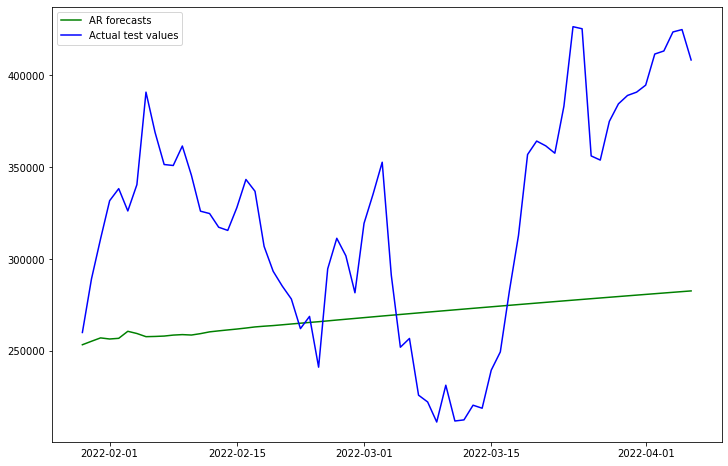

In [62]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.stattools import adfuller
from datetime import datetime


#a_data = sm.datasets.sunspots.load_pandas().data['SUNACTIVITY']
a_data = data.floor_price_quote_7d
split = round(len(a_data)*0.8)

a_train = a_data[:split]
a_test = a_data[split:]
#print(a_test)

a_res = AutoReg(a_train, lags=ar_select_order(a_train, maxlag=20, ic='aic').ar_lags).fit()
#print(ar_select_order(a_train, maxlag=100).ar_lags)
#print(ar_select_order(a_train, maxlag=20,seasonal=True,period=11).ar_lags)
#print(a_res.params)        ar_select_order(a_train, maxlag=100).ar_lags ## ar_select_order(a_train, maxlag=20,seasonal=True,period=11).ar_lags
#print(a_res.summary())

a_data.index = pd.DatetimeIndex(a_data.index.values, freq=a_data.index.inferred_freq)

pdict = a_res.predict(start=datetime(2022, 1, 29), end=datetime(2022, 4, 6), dynamic=False)

fig = plt.subplots(figsize=(12,8))
plt.plot(pdict, color="green")
plt.plot(a_test, color="blue")
plt.legend(["AR forecasts", "Actual test values"])
plt.show()

In [55]:

print(a_data.index)

DatetimeIndex(['2021-04-30', '2021-05-01', '2021-05-02', '2021-05-03',
               '2021-05-04', '2021-05-05', '2021-05-06', '2021-05-07',
               '2021-05-08', '2021-05-09',
               ...
               '2022-03-28', '2022-03-29', '2022-03-30', '2022-03-31',
               '2022-04-01', '2022-04-02', '2022-04-03', '2022-04-04',
               '2022-04-05', '2022-04-06'],
              dtype='datetime64[ns]', length=342, freq='D')


In [ ]:
################################
## Finding optimal parameters for ARIMA##
################################
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, 
                      # m=1,             
                      d=None,           
                      seasonal=False,   
                      trace=True, 
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=42)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5729.675, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5735.080, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5728.820, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5728.163, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5735.909, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5729.880, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5731.750, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5728.210, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.179 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  274
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2861.081
Date:                Sat, 03 Sep 2022   AIC                           5728.163
Time:                        11:22:0

In [ ]:
################################
## Finding optimal parameters for SARIMA##
################################

s_model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, 
                      # m=1,             
                      d=None,           
                      seasonal=True, #this makes it SARIMA  
                      trace=True, 
                      suppress_warnings=True, 
                      stepwise=True,
                      random_state=69)
print(s_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5729.675, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5735.080, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5728.820, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5728.163, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5735.909, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5729.880, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5731.750, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5728.210, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.171 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  274
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2861.081
Date:                Sat, 03 Sep 2022   AIC                           5728.163
Time:                        11:22:0

### 3.3 Final Model

According to the automatic runs, the best model is ARIMA(1,1,0)(0,0,0), which is a model with first difference and one lag of the first difference. There is no seasonality or constant term (intercept) in the model.

ARIMA(7,1,0)(0,0,0)[0]

#### 3.3.1 Residuals check
Once the final model is run, it's essential to also check the residuals to see if all the assumptions of ARIMA models are met. Four components of the residuals are checked:

Standardised residual: The errors fluctuate around a mean of zero and have a constant uniform variance.

Density: The empirical density and the kernal density estimation (KDE) of the floor price series suggest it has a mean of zero but has a thinner and more pointy shape than a normal distribution.

QQ Plot: The QQ-plot of the floor price against a normal distribution shows not all the dots are around the red line. The deviations towards the negative values imply the distribution is skewed, the same conclusion from the density plot.

Correlogram: The correlogram (or ACF) plot shows most of the points are within the confidence interval, so the residual errors are not autocorrelated. However, there is one point that pushes far to the negative side, which indicates there might be some pattern in the residuals that are not explained in the model. Adding more predictors (explanatory variables) might help improve the model.

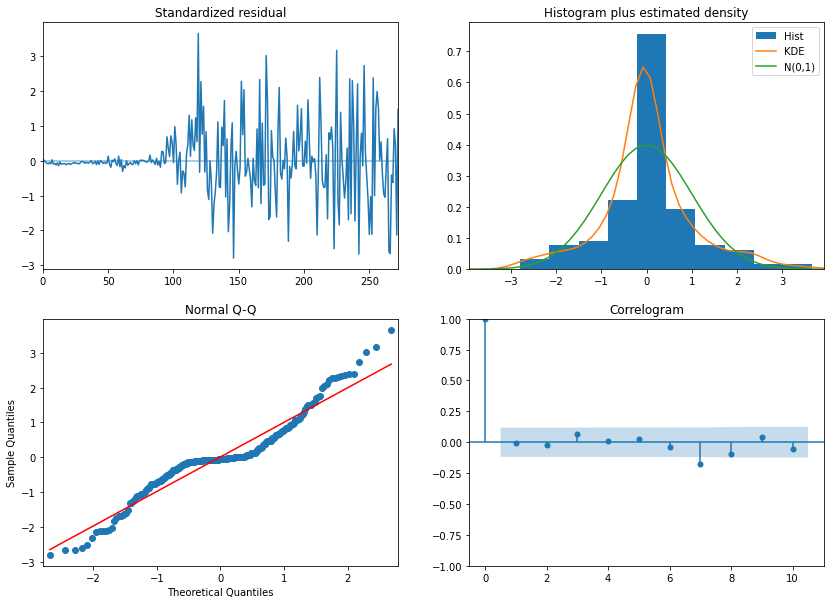

In [ ]:
## Check residuals
model.plot_diagnostics(figsize=(14,10))
plt.show()

#### 3.3.2 Forecast
Using the optimal model ARIMA(1,1,0) trained from historic data from April 30th 2021 to November 24th 2021, you can predict the floor price from November 25th 2021 to January 15th 2022.


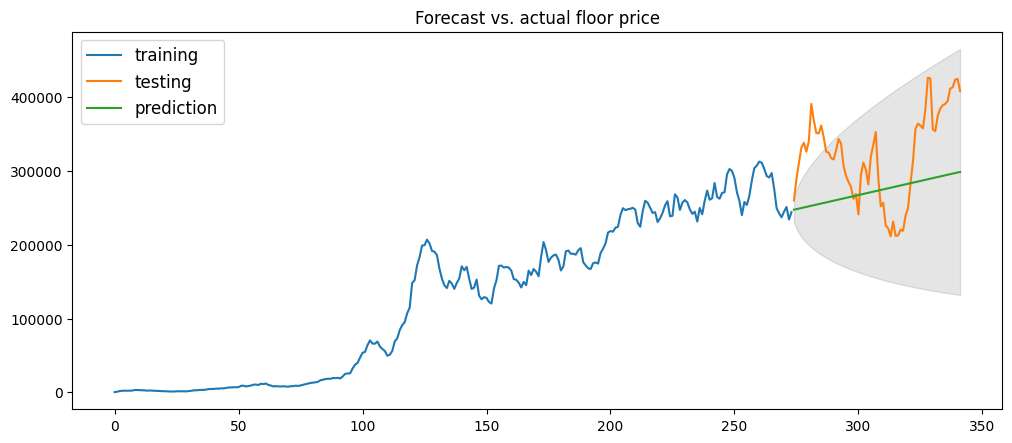

In [ ]:
################
## Prediction ##
################
s_pred, ci = s_model.predict(n_periods = len(test), return_conf_int=True)
s_idx = np.arange(len(train), len(train) + len(test))


s_test_pred = pd.Series(s_pred, index = s_idx)
s_lb = pd.Series(ci[:, 0], index = s_idx)
s_ub = pd.Series(ci[:, 1], index = s_idx)

# Plot
s_plot_train = train.reset_index()
s_plot_test = pd.DataFrame(test).set_index(s_idx)
s_plot_pred = pd.DataFrame(s_test_pred).set_index(s_idx)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(s_plot_train.floor_price_quote_7d, label = "training")
plt.plot(s_plot_test.floor_price_quote_7d, label = "testing")
plt.plot(s_plot_pred, label = "prediction")
plt.fill_between(s_lb.index, s_lb, s_ub, color='k', alpha = 0.1)
plt.legend(loc='upper left', fontsize = 12)
plt.title("Forecast vs. actual floor price")
plt.show()

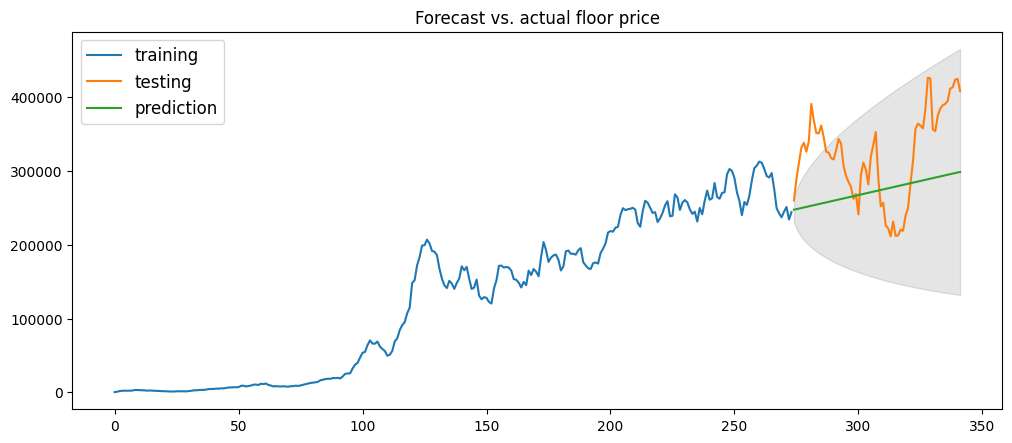

In [ ]:
################
## Prediction ##
################
pred, ci = model.predict(n_periods = len(test), return_conf_int=True)
idx = np.arange(len(train), len(train) + len(test))


test_pred = pd.Series(pred, index = idx)
lb = pd.Series(ci[:, 0], index = idx)
ub = pd.Series(ci[:, 1], index = idx)

# Plot
plot_train = train.reset_index()
plot_test = pd.DataFrame(test).set_index(idx)
plot_pred = pd.DataFrame(test_pred).set_index(idx)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(plot_train.floor_price_quote_7d, label = "training")
plt.plot(plot_test.floor_price_quote_7d, label = "testing")
plt.plot(plot_pred, label = "prediction")
plt.fill_between(lb.index, lb, ub, color='k', alpha = 0.1)
plt.legend(loc='upper left', fontsize = 12)
plt.title("Forecast vs. actual floor price")
plt.show()


#### 3.3.3 Peformance
The model performance metrics compare the predicted and the actual floor price during the testing period from November 25th 2021 to January 15th 2022. The mean absolute percentage error of 6.2% means the model is approximately 93.8% accurate in predicting the next 52 days.

In [ ]:
## Performance metrics
actual = pd.DataFrame(test).reset_index()
actual.columns = ['date','actual']

predict = pd.DataFrame(test_pred).reset_index()
predict.columns = ['date','predict']

accuracy(predict['predict'], actual['actual'])

{'Mean absolute percentage error': 0.19894706076688498,
 'Root mean squared error': 74919.89346455934,
 'corr': 0.2957063761541203}

## 4. Conclusion

This notebook shows an example of how to use Covalent API to download historic daily NFT floor price; and build a simple time-series ARIMA model. Although the model performance is not bad, there are a few limitations and improvments that can be made:

- The residuals from the ARIMA (1,1,0) model are not exactly normally distributed, indicating there might be room to improve the model by adding some more exogenous variables such as sale volumes or even traits of the collection.
- Only a short history of daily floor price is used to predict BAYC in the example. There probably hasn't been enough cycles (ups and downs in trend) in the history for the model to be trained to predict well in the future.
- ARIMA is a generic and simple time-series model. There could be other models and also other exogenous variables that can be used to build a better model.